# Predicting compliance for blight tickets in Detroit

In [1]:
%matplotlib notebook
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from pandas_summary import DataFrameSummary

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import roc_curve, auc

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import cross_val_score
from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import LabelEncoder, StandardScaler, LabelBinarizer, OneHotEncoder
from sklearn.model_selection import GridSearchCV

/home/cyrfar/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
#merge training set with addresses and coordinates (we assume they are all in the current dir).
train = pd.read_csv('train.csv', encoding='mac_roman')
test = pd.read_csv('test.csv')
addresses = pd.read_csv('addresses.csv')
latlons = pd.read_csv('latlons.csv')

train = train.merge(pd.merge(addresses, latlons, on ='address', how ='inner'), on ='ticket_id', how = 'inner');
test = test.merge(pd.merge(addresses, latlons, on ='address', how ='inner'), on ='ticket_id', how = 'inner');

/home/cyrfar/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2683: DtypeWarning: Columns (11,12,31) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Let us define some useful lists

In [3]:
#Use these two lines of codes to obtain the Detroit_with_typos word set below:
#filtered = list(filter(lambda x: x not in Detroit_with_typos, train['city']))
#set([c for c in filtered if c.startswith('DET')])

Detroit_with_typos = set(
['DETROIT', 'Detroit', 'DETORIT', 'DETROT', 'Detrot', 'detroit', 'detrot',
 'DET', 'DETROI', 'DETROIR', 'DET.', 'DETRIOIT', 'Det', 'D', 'det', 'd',
 'DERTROIT', 'DETRIOT', 'DETRIT', 'Deroit', 'detriot', 'DEROT', 'DETRPOT',
 'Detorit','DETRTOI', 'DET,', 'DETR4OIT', 'DETRIUT', 'DEROIT', 'DEt',
 'Det.', 'DETOIT', 'DERTOIT',  'DEETROIT', 'DETROTI', 'DTEROIT','DETROIOT',
 'DETROIT1','DETROITQ', 'DET ,', 'DET ROIT', 'DET,.', 'DET. MI.', 'DET.,',
 'DET., MI.', 'DETAROIT', 'DETEOIT', 'DETEROIT', 'DETORIIT', 'DETREOIT',
 'DTROIT', 'DETRIOIT', 'DETRJOIT', 'DETROIIT', 'DETROIRT', 'DETROIS',
 'DETROIT  4', 'DETROIT,', 'DETROIT, MI.', 'DETROIT, MI. 48206', 'DETROITF',
 'DETROITI', 'DETROITL', 'DETROITM', 'DETROITT', 'DETROITY','DETROIT`', 
 'DETROITdetroit', 'DETROIYT', 'DETROKT', 'DETROOIT', 'DETROPIT',
 'DETROUIT', 'DETRROIT', 'DETTROIT', 'DETTROITM', 'DETYROIT', 'DETZVILLE',
 'Det', 'Detrioit', 'Detriot', 'Detriut','Detro;it', 'Detrofit', 'Detroi', 
 'Detroir', 'Detroit`', 'Detroitf', 'Detroitli', 'Detroti', 'Detrroit',
 'Dteroit', 'dteroit', 'DEtroit', 'cetroit', 'deroit', 'dertoit', 
 'deteroit', 'detoit', 'detrtoit', 'BELOIT', 'CETROIT', 'DEEEEETROIT',
 'DERROIT', 'DEYROIT', 'DFETROIT', 'DKETROIT', 'DRTROIT', 'DWETROIT',
 'EAST  DETROIT', 'ETROIT','WARRENDETROIT', 'dETROIT','det.', 'det48234',
 'detroiit', 'detroiot', 'detroir', 'detroit,mi', 'detroit`', 'detroitt',
 'detrorit', 'DE',  'DD', 'DDD', 'DDDDDD', 'DDDDDDD', 'DDDDDDDD', 'deT'])

#These columns will be dropped due to potential leakage during preprocessing
data_leakage = set(
['payment_amount', 'payment_date', 'payment_status', 'balance_due',
 'collection_status', 'compliance_detail'])

#These columns will be dropped during preprocessing
drop_these = [
'inspector_name', 'violation_street_number', 'violation_street_name',
'violation_zip_code', 'violator_name', 'violation_description', 'address', 
'ticket_issued_date', 'hearing_date', 'mailing_address_str_number', 
'mailing_address_str_name', 'city', 'state', 'judgment_amount','zip_code',
'non_us_str_code', 'country', 'grafitti_status', 'admin_fee', 'state_fee',
'late_fee', 'discount_amount', 'clean_up_cost', 'agency_name', 'violation_code']
#note: only one person has a non-NAN entry in graffity_status column,
#so we can just drop it

#Relevant categorical, binary and numeric variables that we will use during trainings
cat_vars = ['disposition', 'mailing_non_USA', 'mailing_non_DT', 'mailing_non_MI']
num_vars = ['fine_amount', 'days_from_issue_to_hearing', 'lat', 'lon']

#Elements of set(X_test['disposition']) that will be replaced during preprocessing
replace = ['Responsible - Compl/Adj by Determi', 'Responsible by Dismissal', 
           'Responsible (Fine Waived) by Admis', 'Responsible - Compl/Adj by Default']

Let us define some functions:

In [4]:
def preprocess(train, test):
    '''Create new fields and clean the train and test data'''
    for df in [train, test]:        
        #create new features using the mailing address of violator
        df['mailing_non_USA'] = [1 if country not in ['USA'] else 0 for country in df['country']]
        df['mailing_non_DT'] = [1 if city not in Detroit_with_typos else 0 for city in df['city']]
        df['mailing_non_MI'] = [1 if state not in ['MI'] else 0 for state in df['state']]

        #create a new feature: the number of days elaspsed from the ticket-issue-day to the hearing day
        df['ticket_issued_date'] = pd.to_datetime(df['ticket_issued_date'])
        df['hearing_date'] = pd.to_datetime(df['hearing_date'])
        delta = df['hearing_date'] - df['ticket_issued_date']
        df.loc[delta.notnull(), 'days_from_issue_to_hearing'] = delta.dt.days

        #drop potential data leaking fields
        if set(df.columns).intersection(data_leakage):
            df = df.drop(data_leakage, axis = 1)
            
        #drop these irrelevant fields, or fields with mostly NA's in them
        df = df.drop(drop_these, axis = 1)
    
        #cleaning missing data 
        df['days_from_issue_to_hearing'].fillna(np.mean(df['days_from_issue_to_hearing']), inplace = True)
        #df['violation_code'].fillna(' ', inplace = True)
        df['fine_amount'].fillna(np.mean(df['fine_amount']), inplace = True)
        df['lat'].fillna(np.mean(df['lat']), inplace = True)
        df['lon'].fillna(np.mean(df['lon']), inplace = True)

        if set(df.columns).intersection(set(['compliance'])):
            #trim traininig data:
            df = df.dropna(axis=0)
            df.reset_index(inplace=True, drop=True)
            X_train = df.drop('compliance',axis =1)            
            y_train = pd.DataFrame(df['compliance'])
        else: 
            #trim test data:
            #Replace elements of set(X_test['disposition']) that do not appear
            #in set(X_train['disposition']), with 'Responsible by Default'.
            df['disposition'].replace(replace, 'Responsible by Default', inplace=True)
            X_test = df
    return X_train, X_test, y_train

def EncoderScaler(X_train, X_test):
    X1 = pd.get_dummies(X_train[cat_vars])
    scaler = StandardScaler().fit(X_train[num_vars])
    X2 = pd.DataFrame(scaler.transform(X_train[num_vars]), columns = num_vars)
    X_train_map = X1.join(X2)
    mean =np.mean(X_train_map['days_from_issue_to_hearing'])
    X_train_map['days_from_issue_to_hearing'].fillna(mean, inplace = True)
    X_train_map['lat'].fillna(np.mean(X_train_map['lat']), inplace = True)
    X_train_map['lon'].fillna(np.mean(X_train_map['lon']), inplace = True)
    X_train_map['fine_amount'].fillna(np.mean(X_train_map['fine_amount']),
     inplace = True)
    X_train_map.reset_index(inplace=True, drop=True)
    X3 = pd.get_dummies(X_test[cat_vars])
    X4 = pd.DataFrame(scaler.transform(X_test[num_vars]), columns = num_vars)
    X_test_map = X3.join(X4)
    return X_train_map, X_test_map
    
def train_vs_val_err(X_train, y_train, model):
    '''Returns training and validation AUC scores'''
    X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, random_state=0)
    model.fit(np.array(X_tr),np.array(y_tr))

    y_pred_tr = model.predict_proba(np.array(X_tr))
    fpr_tr, tpr_tr, _ = roc_curve(y_tr, y_pred_tr[:,1])
    roc_auc_tr = auc(fpr_tr, tpr_tr)

    y_pred_val = model.predict_proba(np.array(X_val))
    fpr_val, tpr_val, _ = roc_curve(y_val, y_pred_val[:,1])
    roc_auc_val = auc(fpr_val, tpr_val)
    return roc_auc_tr, roc_auc_val

def ROC_curve(X_train, y_train, model):
    '''Calculates AUC score on the validation set and plots the ROC curve'''
    if model == rfc: name = 'Random Forrest'
    else: name = 'Grd. Boost'
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=0)
    model.fit(X_train,y_train)
    y_pred = model.predict_proba(X_val)
    fpr, tpr, _ = roc_curve(y_val, y_pred[:,1])
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.xlim([-0.01, 1.00])
    plt.ylim([-0.01, 1.01])
    plt.plot(fpr, tpr, lw=3, label='{:s} (area = {:0.3f})'.format(name, roc_auc))
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.title('ROC curve (Detroit blight model)', fontsize=16)
    plt.legend(loc='lower right', fontsize=13)
    plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
    plt.axes().set_aspect('equal')
    plt.show()

Now we use these functions 

In [5]:
        #get data with the relevant features
X_train, X_test, y_train = preprocess(train, test)
print(X_train.shape, X_test.shape, y_train.shape)
DataFrameSummary(X_test).summary()

(159880, 9) (61001, 9) (159880, 1)


,ticket_id,disposition,fine_amount,lat,lon,mailing_non_USA,mailing_non_DT,mailing_non_MI,days_from_issue_to_hearing
count,61001,NaN,61001,61001,61001,61001,61001,61001,61001
mean,331725,NaN,272.714,42.3926,-83.1177,0,0.484336,0.149752,36.1507
std,25434.9,NaN,360.102,0.0376705,0.0989629,0,0.499759,0.356831,23.6097
min,284932,NaN,0,42.231,-83.7914,0,0,0,-337
25%,310111,NaN,50,42.3652,-83.2012,0,0,0,22
50%,332251,NaN,200,42.402,-83.1389,0,0,0,30
75%,353031,NaN,250,42.4228,-83.0388,0,1,0,43
max,376698,NaN,10000,42.5545,-82.8889,0,1,1,1014
counts,61001,61001,61001,61001,61001,61001,61001,61001,61001
uniques,61001,4,53,31265,32626,1,2,2,242


In [6]:
#process data
X_train_map, X_test_map = EncoderScaler(X_train, X_test)
print(X_train_map.shape, X_test_map.shape, y_train.shape)
print(X_train_map.columns)
print(X_test_map.columns)
print(y_train.columns)

(159880, 11) (61001, 11) (159880, 1)
Index(['mailing_non_USA', 'mailing_non_DT', 'mailing_non_MI',
       'disposition_Responsible (Fine Waived) by Deter',
       'disposition_Responsible by Admission',
       'disposition_Responsible by Default',
       'disposition_Responsible by Determination', 'fine_amount',
       'days_from_issue_to_hearing', 'lat', 'lon'],
      dtype='object')
Index(['mailing_non_USA', 'mailing_non_DT', 'mailing_non_MI',
       'disposition_Responsible (Fine Waived) by Deter',
       'disposition_Responsible by Admission',
       'disposition_Responsible by Default',
       'disposition_Responsible by Determination', 'fine_amount',
       'days_from_issue_to_hearing', 'lat', 'lon'],
      dtype='object')
Index(['compliance'], dtype='object')


We now define our models to test

In [ ]:
#random forrest classifier
rfc = RandomForestClassifier(n_estimators = 100, max_depth =3, n_jobs=-1, random_state=0)

#gradient boost classifier
grd = GradientBoostingClassifier(n_estimators=100, max_depth = 3, min_samples_split=50, 
                                 min_samples_leaf=10, learning_rate=0.05 , random_state=0)

and evaluate them using a validation set

In [8]:
#compare train and validation AUC scores to check if rfc is overfitting
train_vs_val_err(X_train_map, y_train, rfc)

/home/cyrfar/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


(0.78247937965136294, 0.77848097151852957)

In [17]:
#compare train and validation AUC scores to check if grd is overfitting
train_vs_val_err(X_train_map, y_train, grd)

/home/cyrfar/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(0.82195148849939781, 0.79804525665568238)

/home/cyrfar/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


<IPython.core.display.Javascript object>


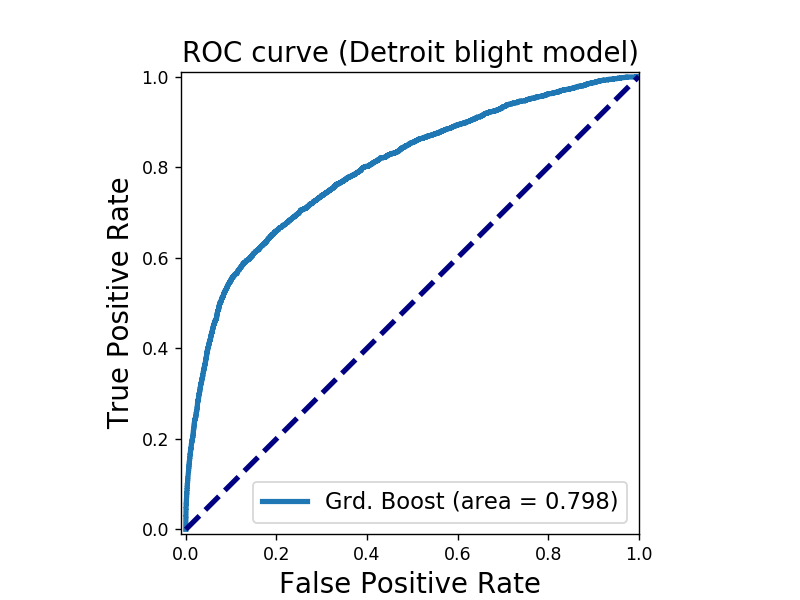

In [18]:
#plot ROC curve for grd
ROC_curve(X_train_map, y_train, grd)

Construct a data series for the 'compliance' probability with 'ticket_id' as index 

In [19]:
model = grd
model.fit(np.array(X_train_map),np.array(y_train))
y_pred = model.predict_proba(np.array(X_test_map))
y_pred = pd.Series(y_pred[:,1], index =X_test['ticket_id'].tolist(), name='compliance');
y_pred.head()

/home/cyrfar/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


284932    0.038800
285362    0.009054
285361    0.066130
285338    0.090330
285346    0.100424
Name: compliance, dtype: float64

Upon submission, this model gave a AUC of 0.772 in the leaderboard putting the model in a top 10 position